*   ベースディレクトリと、出力ディレクトリを設定します。

In [1]:
############################################
BaseDir      = 'IntroDDSJpn/Chap01/'
OutputDir    = '1Error-0108Mmeans/'
FileBaseName = '1Error-0108Mmeans'

*   Google Colabかどうかを判別し、このJupyter Notebookのあるディレクトリを特定します。

In [2]:
############################################
import sys
import os
############################################
def IsGoogleColab():
  if 'google.colab' in sys.modules:
    return True
  else:
    return False
############################################
if IsGoogleColab():
  #
  from google.colab import drive
  drive.mount('/content/drive')
  #
  IpynbDir = 'drive/My Drive/Colab Notebooks/' + BaseDir
else:
  #
  IpynbDir =  os.getcwd() + '/'
############################################
print( 'ipynb file path = %s' % IpynbDir )

ipynb file path = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap01/


*   必要なパッケージを読み込み、ファイルの出力先のディレクトリを用意します。

In [3]:
############################################
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
print('matplotlib Ver.', mpl.__version__)
#
############################################
import numpy as np
print('numpy      Ver.', np.__version__)
#
############################################
import sklearn as skl
print('sklearn    Ver.', skl.__version__)
#
############################################
import pandas as pd
print('pandas     Ver.', pd.__version__)
#
############################################
FilePath = IpynbDir + OutputDir
print( 'FilePath = %s' % FilePath )
#
if( True != os.path.isdir(FilePath) ):
    print('  making %s' % FilePath )
    os.mkdir(FilePath)
else:
    print(' %s is exist.' % FilePath )

matplotlib Ver. 3.9.2
numpy      Ver. 1.26.4
sklearn    Ver. 1.5.2
pandas     Ver. 2.2.3
FilePath = d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap01/1Error-0108Mmeans/
 d:\home\iakai\CY\Docs\Kuma3Curriculum\2025森北出版\GitHubIntroDDSJpn\IntroDDSJpn\Chap01/1Error-0108Mmeans/ is exist.


最確値を書式化して文字列として返す関数
Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False )
*   返値: 書式化された文字列を返す。
*   v_mean: 平均値
*   v_std:  標準偏差
*   s_unit: 値の単位(文字列)
*   std_2digit=True: 標準偏差を2桁表示。Falseにすると1桁表示
*   latex=False: テキスト文字列として出力。Trueでは、図などでlatex表示できる文字列で出力。

In [4]:
def Format_MostProbableValue( v_mean, v_std, s_unit, std_2digits=True, latex=False ):
  #
  # 平均値の冪数
  order_mean = np.floor( np.log10(v_mean) )
  # print( 'order_mean=', order_mean )
  #
  # 標準偏差の冪数
  if std_2digits:
    # 標準偏差を有効2桁表示
    order_std  = np.floor( np.log10(v_std) - 1.0 )
  else:
    # 標準偏差を有効1桁表示
    order_std  = np.floor( np.log10(v_std) - 0.0 )
  # print( 'order_std=', order_std )
  #
  # 平均値の冪数と標準偏差の冪数の符号が同じか?
  if order_mean * order_std > 0.0:
    # 例1
    # v_mean = 4.60572E5
    # v_std  = 8.96E3
    # 例2
    # v_mean = 4.605723E-2
    # v_std  = 8.96E-5
    multi_order = order_std+1
    #
    # 共通する冪数
    multi = 10.0**multi_order
    #
    # 共通する冪数で規格化
    v_mean = v_mean / multi
    v_std  = v_std  / multi
    #
    # 共通した冪数で指数をくくって、係数は少数第1位
    if latex:
      out_str = r'(%+.1f $\pm$ %.1f)$\times10^{%+d}$ ' % (v_mean, v_std, multi_order) + s_unit
    else:
      out_str = '(%+.1f +/- %.1f)x10^(%+d) ' % (v_mean, v_std, multi_order) + s_unit
    #
  else:
    # 平均値の冪数と標準偏差の冪数の符号が異なる
    # 例2
    # v_mean = 4.605723
    # v_std  = 0.0896
    fmt_std1 = r'$%%+.%df$' % -order_std
    fmt_std2 = r'$%%.%df$'  % -order_std
    if latex:
      fmt_str = fmt_std1 + r' $\pm$ ' + fmt_std2 + ' ' + s_unit
    else:
      fmt_str = fmt_std1 + ' +/- ' + fmt_std2 + ' ' + s_unit
    #
    out_str = fmt_str % (v_mean, v_std)
  #
  return out_str

1.1.5 測定値の分布(ヒストグラム)

まずヒストグラムを描く関数を定義する。

In [5]:
############################################
def GrfHist( data, bins_conf, y_label='Distribution', x_label=r'$x$', y_max=None, hist_label=None, title=None, color='white', edgecolor='black' ):
    #
    # 平均値と標準偏差
    data_mean_ = np.mean( data )
    data_std_  = np.std( data )
    #
    # ヒストグラムのbinsの設定
    if (type( bins_conf ) is tuple) and len(bins_conf)==3 :
      #
      # (xleft, xstep, xright)をtupleで指定した場合
      #
      xleft_  = bins_conf[0]
      xstep_  = bins_conf[1]
      xright_ = bins_conf[2]
      #
      bins_ = int( np.ceil( (xright_ - xleft_) / xstep_ + 0.5 ) )
      # print( bins_ )
      xright_ = xleft_ + bins_ * xstep_
      x_range_ = (xleft_, xright_)
      # print( x_range_ )
      #
    else:
      #
      # binsだけを指定している場合
      #
      bins_    = bins_conf
      x_range_ = (np.amin(data), np.amax(data))
    #
    ########################################
    plt.rcParams['font.size'] = 24
    #
    fig = plt.figure( figsize=(8,6) )
    #
    # タイトルが指定された場合は、top marginを増加させる
    if title is not None:
      fig.subplots_adjust(left=0.20, right=0.95, top=0.90, bottom=0.2)
    else:
      fig.subplots_adjust(left=0.20, right=0.95, top=0.94, bottom=0.2)
    #
    # 1つ目のグラフの軸を生成する
    ax1 = fig.add_subplot(1,1,1)
    #
    # 軸ラベル
    ax1.set_xlabel( x_label )
    ax1.set_ylabel( y_label )
    #
    # ヒストグラムデータを用意する。
    bin_values, bin_x = np.histogram( data, bins=bins_, range=x_range_, density=False )
    #
    # bin_x は区間の境界データで、bin_valuesよりも要素が1つ多い
    bin_xs = np.zeros( len( bin_values ) )
    #
    # 1つの bin の両端の平均値として、横軸を用意する
    for idx in range( len( bin_values ) ):
      bin_xs[idx] = (bin_x[idx] + bin_x[idx+1])/2.0
      idx = idx + 1
    #
    # ヒストグラムを棒グラフで描く
    ax1.bar( bin_xs, bin_values, width=xstep_, label=hist_label, color=color, edgecolor=edgecolor, linewidth=1.0 )
    # ax1.plot( bin_xs, bin_values, label=histlabel )
    #
    # y軸の最大値
    bin_values_max = np.amax( bin_values )
    #
    if y_max is not None:
      (y_bot, y_top) = ax1.set_ylim( (0, y_max) )
    else:
      # y軸の上端を最大値の1.2倍とし、そのylimを取得する
      (y_bot, y_top) = ax1.set_ylim( (0, bin_values_max * 1.2) )
    #
    # x軸の範囲
    ax1.set_xlim( xleft_, xright_ )
    #
    # bins が10未満なら、横軸の目盛りをそれで打つ
    if len( bin_xs ) < 10:
      ax1.set_xticks( bin_xs )
    #
    # 横軸の目盛り数値が重ならないように、90度回転させる
    plt.xticks(rotation=90)
    #
    # 平均値と標準偏差の範囲を縦線で示す。
    ax1.axvline( data_mean_,           y_bot, y_top, label=r'$\overline{x}$',        color='green' )
    ax1.axvline( data_mean_-data_std_, y_bot, y_top, label=r'$\overline{x}-\sigma$', color='blue', linestyle='dotted' )
    ax1.axvline( data_mean_+data_std_, y_bot, y_top, label=r'$\overline{x}+\sigma$', color='red',  linestyle='dotted' )
    #
    if title is not None:
      plt.title( title, fontsize=22 )
    #
    plt.legend()
    #
    plt.show()
    #
    return fig

図1.4(b)のデータを用いる。

10000回測定のデータを読み込む

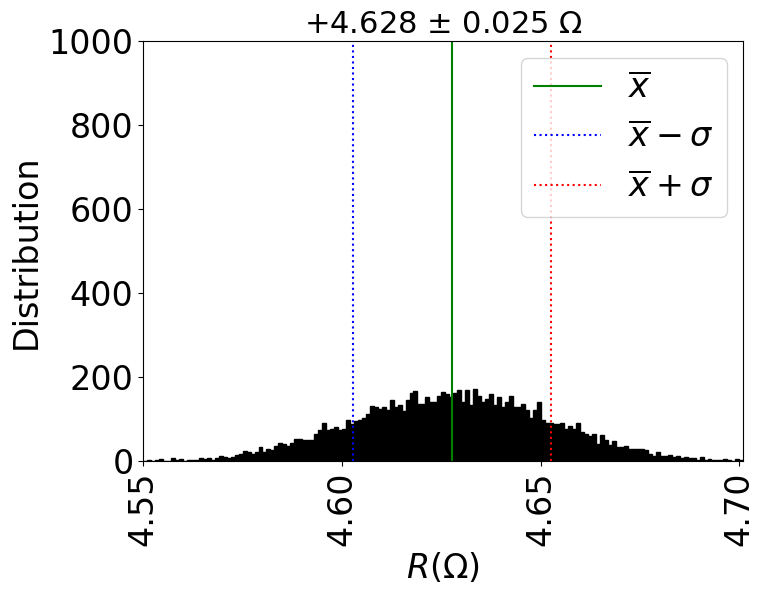

In [7]:
############################################
# Excelファイルからデータを読み込み、arrayに
# 変換するする
#
excelFile = IpynbDir + FileBaseName + '-R-N10000.xlsx'
df_Rdata = pd.read_excel( excelFile, header=None )
#
Rdata = np.array( df_Rdata[0] )
Rdata_mean = np.mean( Rdata )
Rdata_std  = np.std( Rdata )
title = Format_MostProbableValue( Rdata_mean, Rdata_std, r'$\Omega$', latex=True )
############################################
fig = GrfHist( Rdata, (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=1000, color='black', edgecolor='black' )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-data.pdf'
fig.savefig( pdf_path )

ランダム抽出による平均値の分布
1.   ${\cal M}$個の測定値$x_1$, $x_2$, $\cdots$, $x_{\cal M}$が入った箱と、抽出して求める平均値を入れる箱を用意する。
2.   ${\cal M}$個の測定値のうち、$M$個の測定値をランダム抽出し、それらから次式より平均値$\overline{x}_{1}$を求め、平均値を入れる箱に入れる。その後、抽出した測定値を測定値を入れた箱に戻す。
$$
    \overline{x}=\frac{1}{M}\sum_{m=1}^{M}x_{m}
$$
3.   再び$M$個の測定値をランダム抽出し平均値$\overline{x}_{2}$を求め、平均値を入れる箱に入れる。その後、抽出した測定値を測定値を入れた箱に戻す。
4.   これを繰り返し、$\overline{x}_{1}$, $\cdots$, $\overline{x}_{\cal M}$の平均値を得る。

$M=8$の平均の分布

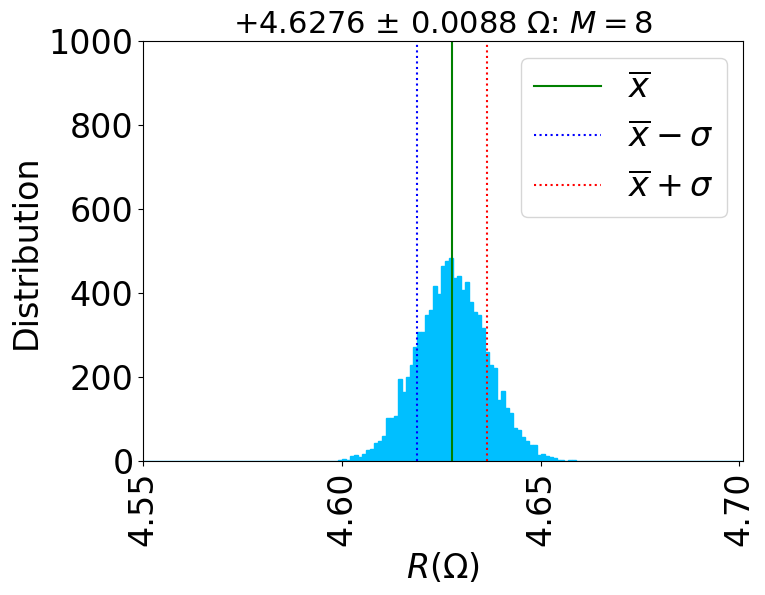

In [8]:
############################################
# M: 母集団のデータ数
Rdata_M = len( Rdata )
#
############################################
# m: 平均をとる点数
mean_m = 8
#
# 平均値を格納する箱
means = []
#
# 平均を求める操作をN回繰り返す。
for i in range( Rdata_M ):
  #
  # 平均値を求めるデータのランダム抽出
  mean_idx = []
  for ii in range(mean_m):
    rnd_idx = np.random.randint( Rdata_M, size=1 )
    # 重複抜粋を避ける
    while rnd_idx in mean_idx:
      rnd_idx = np.random.randint( Rdata_M, size=1 )
    #
    mean_idx.append( rnd_idx )
  #
  # 平均をとるデータを抜き出す
  Rdata_Mean = []
  for ii in range(mean_m):
    Rdata_Mean.append( Rdata[ mean_idx[ii] ] )
  #
  # 求めた平均値を平均値を格納する箱に格納
  means.append( np.mean( Rdata_Mean ) )
#
means_mean = np.mean( means )
means_std  = np.std( means )
title = Format_MostProbableValue( means_mean, means_std, r'$\Omega$', latex=True ) + r': $M=%d$'% mean_m
############################################
fig = GrfHist( means, (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=1000, color='deepskyblue', edgecolor='deepskyblue' )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-m%02d.pdf' % mean_m
fig.savefig( pdf_path )

$M=32$の平均の分布

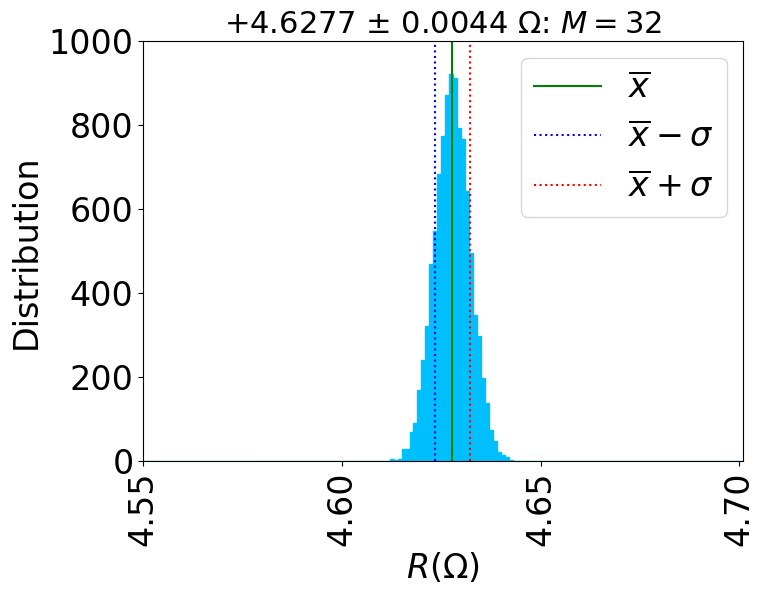

In [9]:
############################################
# N: 母集団のデータ数
Rdata_M = len( Rdata )
#
############################################
# n: 平均をとる点数
mean_m = 32
#
# 平均値を格納する箱
means = []
#
# 平均を求める操作をN回繰り返す。
for i in range( Rdata_M ):
  #
  # 平均値を求めるデータのランダム抽出
  mean_idx = []
  for ii in range(mean_m):
    rnd_idx = np.random.randint( Rdata_M, size=1 )
    # 重複抜粋を避ける
    while rnd_idx in mean_idx:
      rnd_idx = np.random.randint( Rdata_M, size=1 )
    #
    mean_idx.append( rnd_idx )
  #
  # 平均をとるデータを抜き出す
  Rdata_Mean = []
  for ii in range(mean_m):
    Rdata_Mean.append( Rdata[ mean_idx[ii] ] )
  #
  # 求めた平均値を平均値を格納する箱に格納
  means.append( np.mean( Rdata_Mean ) )
#
means_mean = np.mean( means )
means_std  = np.std( means )
title = Format_MostProbableValue( means_mean, means_std, r'$\Omega$', latex=True ) + r': $M=%d$'% mean_m
############################################
fig = GrfHist( means, (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=1000, color='deepskyblue', edgecolor='deepskyblue' )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-m%02d.pdf' % mean_m
fig.savefig( pdf_path )

ヒストグラムを描き、指定した範囲を強調するグラフ

In [10]:
############################################
def GrfHistBound( data, bound_lower, bound_upper, bound_name,
                  bins_conf, y_label='Distribution', x_label=r'$x$', y_max=None, hist_label=None, title=None ):
    #
    # 平均値と標準偏差
    data_mean_ = np.mean( data )
    data_std_  = np.std( data )
    #
    # bound内のデータ
    data_1 = data[ data > bound_lower ]
    data_2 = data_1[ data_1 < bound_upper ]
    #
    # 指定した範囲のデータ数の割合
    data2_ratio = (len(data_2)/len(data)*100.0)
    print( 'ratio = %.3f %%' % data2_ratio )
    #
    # ヒストグラムのbinsの設定
    if (type( bins_conf ) is tuple) and len(bins_conf)==3 :
      #
      # (xleft, xstep, xright)をtupleで指定した場合
      #
      xleft_  = bins_conf[0]
      xstep_  = bins_conf[1]
      xright_ = bins_conf[2]
      #
      bins_ = int( np.ceil( (xright_ - xleft_) / xstep_ + 0.5 ) )
      # print( bins_ )
      xright_ = xleft_ + bins_ * xstep_
      x_range_ = (xleft_, xright_)
      # print( x_range_ )
      #
    else:
      #
      # binsだけを指定している場合
      #
      bins_    = bins_conf
      x_range_ = (np.amin(data), np.amax(data))
    #
    ########################################
    plt.rcParams['font.size'] = 24
    #
    fig = plt.figure( figsize=(8,6) )
    #
    # タイトルが指定された場合は、top marginを増加させる
    if title is not None:
      fig.subplots_adjust(left=0.20, right=0.95, top=0.90, bottom=0.2)
    else:
      fig.subplots_adjust(left=0.20, right=0.95, top=0.94, bottom=0.2)
    #
    # 1つ目のグラフの軸を生成する
    ax1 = fig.add_subplot(1,1,1)
    #
    # 軸ラベル
    ax1.set_xlabel( x_label )
    ax1.set_ylabel( y_label )
    #
    # ヒストグラムデータを用意する。
    bin_values, bin_x = np.histogram( data, bins=bins_, range=x_range_, density=False )
    #
    # bin_x は区間の境界データで、bin_valuesよりも要素が1つ多い
    bin_xs = np.zeros( len( bin_values ) )
    #
    # 1つの bin の両端の平均値として、横軸を用意する
    for idx in range( len( bin_values ) ):
      bin_xs[idx] = (bin_x[idx] + bin_x[idx+1])/2.0
      idx = idx + 1
    #
    # ヒストグラムを棒グラフで描く
    ax1.bar( bin_xs, bin_values, width=xstep_, label=hist_label, color='gray', edgecolor='gray', linewidth=1.0 )
    # ax1.plot( bin_xs, bin_values, label=histlabel )
    #
    # y軸の最大値
    bin_values_max = np.amax( bin_values )
    #
    if y_max is not None:
      (y_bot, y_top) = ax1.set_ylim( (0, y_max) )
    else:
      # y軸の上端を最大値の1.2倍とし、そのylimを取得する
      (y_bot, y_top) = ax1.set_ylim( (0, bin_values_max * 1.2) )
    #
    ############################
    # ヒストグラムデータを用意する。
    bin_values_2, bin_x_2 = np.histogram( data_2, bins=bins_, range=x_range_, density=False )
    #
    # bin_x は区間の境界データで、bin_valuesよりも要素が1つ多い
    bin_xs_2 = np.zeros( len( bin_values_2 ) )
    #
    # 1つの bin の両端の平均値として、横軸を用意する
    for idx in range( len( bin_values_2 ) ):
      bin_xs_2[idx] = (bin_x_2[idx] + bin_x_2[idx+1])/2.0
      idx = idx + 1
    #
    # ヒストグラムを棒グラフで描く
    ax1.bar( bin_xs_2, bin_values_2, width=xstep_, label=hist_label, color='black', edgecolor='black', linewidth=1.0 )
    #
    # x軸の範囲
    ax1.set_xlim( xleft_, xright_ )
    #
    # bins が10未満なら、横軸の目盛りをそれで打つ
    if len( bin_xs ) < 10:
      ax1.set_xticks( bin_xs )
    #
    # 横軸の目盛り数値が重ならないように、90度回転させる
    plt.xticks(rotation=90)
    #
    # 平均値と標準偏差の範囲を縦線で示す。
    ax1.axvline( data_mean_,  y_bot, y_top, label=r'$\overline{x}$',        color='green' )
    ax1.axvline( bound_lower, y_bot, y_top, label=r'$\overline{x}-'+bound_name+'$', color='blue', linestyle='dotted' )
    ax1.axvline( bound_upper, y_bot, y_top, label=r'$\overline{x}+'+bound_name+'$', color='red',  linestyle='dotted' )
    #
    xcenter__ = (xleft_+xright_)/2.0
    ycenter__ = (y_bot+y_top)/2.0
    yheight__ = (y_top-y_bot)/2.0
    ax1.plot( (xcenter__, bound_lower), (ycenter__- yheight__*0.3, ycenter__+ yheight__*0.3), color='green')
    bound_text = r'%.1f %%' % data2_ratio
    ax1.text( bound_lower, ycenter__+ yheight__*0.3, bound_text, color='green', horizontalalignment='right' )
    #
    if title is not None:
      plt.title( title, fontsize=22 )
    #
    plt.legend(loc='upper right')
    #
    plt.show()
    #
    return fig

測定データの$1\sigma$の範囲

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iakai\AppData\Local\Temp\ipykernel_22716\3258373496.py:6: SyntaxWarning: invalid escape sequence '\s'
  fig = GrfHistBound( Rdata, Rdata_lower, Rdata_upper, '\sigma',


ratio = 67.970 %


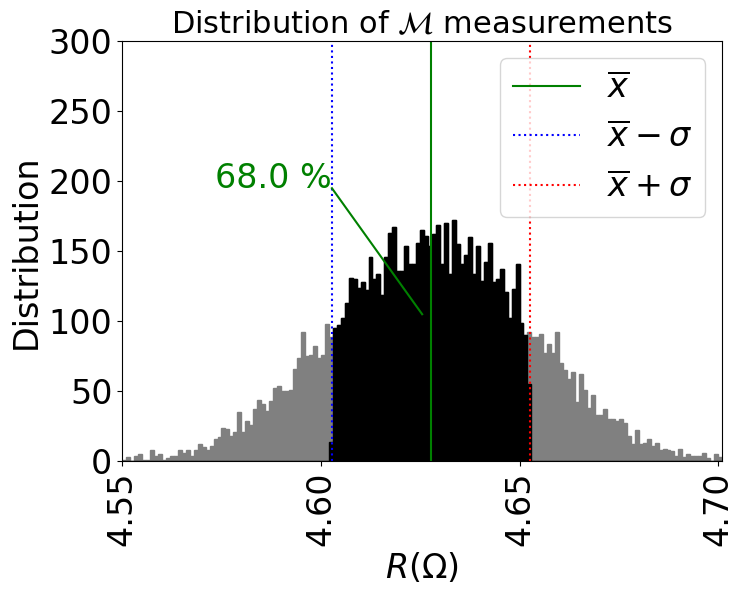

In [11]:
############################################
Rdata_lower = np.mean( Rdata ) - np.std( Rdata )
Rdata_upper = np.mean( Rdata ) + np.std( Rdata )
#
title = r'Distribution of ${\cal M}$ measurements'
fig = GrfHistBound( Rdata, Rdata_lower, Rdata_upper, '\sigma',
                    (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=300 )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-data1sigma.pdf'
fig.savefig( pdf_path )

測定データの$1\epsilon$の範囲

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\iakai\AppData\Local\Temp\ipykernel_22716\358125458.py:6: SyntaxWarning: invalid escape sequence '\e'
  fig = GrfHistBound( Rdata, Rdata_lower, Rdata_upper, '\epsilon',


ratio = 49.470 %


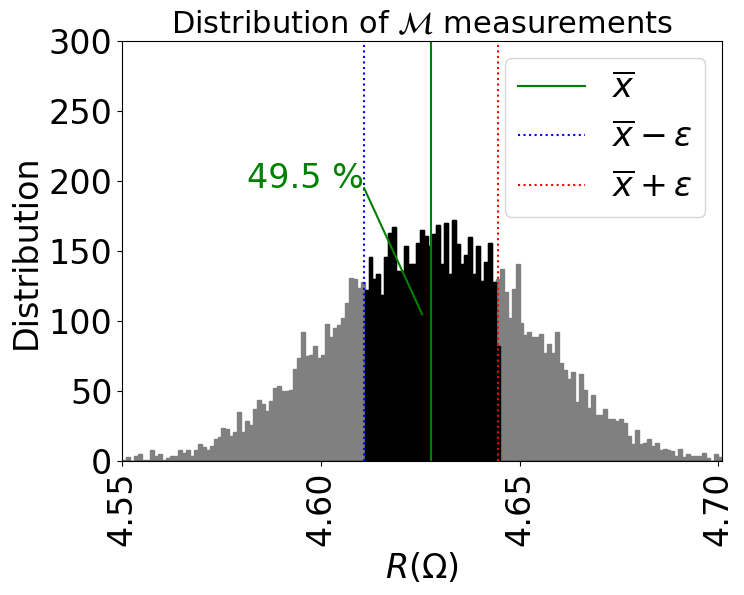

In [12]:
############################################
Rdata_lower = np.mean( Rdata ) - 0.6745 * np.std( Rdata )
Rdata_upper = np.mean( Rdata ) + 0.6745 * np.std( Rdata )
#
title = r'Distribution of ${\cal M}$ measurements'
fig = GrfHistBound( Rdata, Rdata_lower, Rdata_upper, '\epsilon',
                    (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=300 )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-data1epsilon.pdf'
fig.savefig( pdf_path )

$M=4$の平均の分布

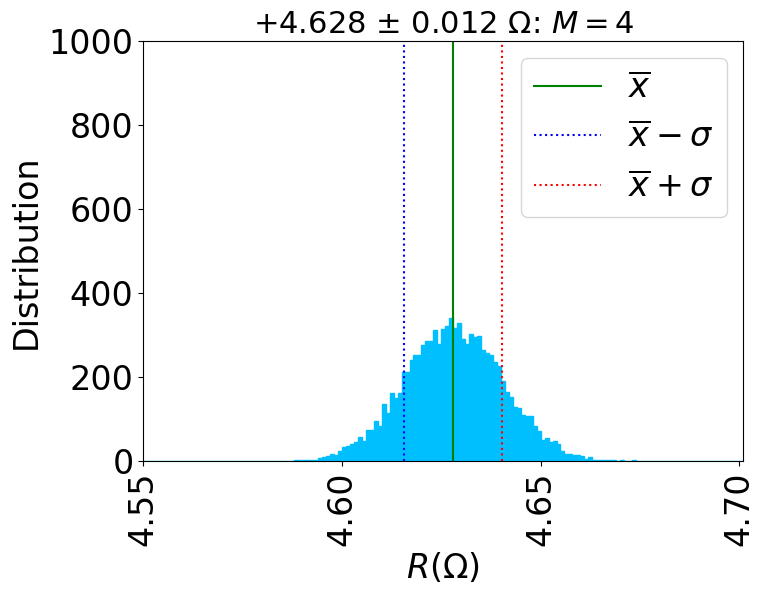

In [13]:
############################################
# M: 母集団のデータ数
Rdata_M = len( Rdata )
#
############################################
# m: 平均をとる点数
mean_m = 4
#
# 平均値を格納する箱
means = []
#
# 平均を求める操作をN回繰り返す。
for i in range( Rdata_M ):
  #
  # 平均値を求めるデータのランダム抽出
  mean_idx = []
  for ii in range(mean_m):
    rnd_idx = np.random.randint( Rdata_M, size=1 )
    # 重複抜粋を避ける
    while rnd_idx in mean_idx:
      rnd_idx = np.random.randint( Rdata_M, size=1 )
    #
    mean_idx.append( rnd_idx )
  #
  # 平均をとるデータを抜き出す
  Rdata_Mean = []
  for ii in range(mean_m):
    Rdata_Mean.append( Rdata[ mean_idx[ii] ] )
  #
  # 求めた平均値を平均値を格納する箱に格納
  means.append( np.mean( Rdata_Mean ) )
#
means_mean = np.mean( means )
means_std  = np.std( means )
title = Format_MostProbableValue( means_mean, means_std, r'$\Omega$', latex=True ) + r': $M=%d$'% mean_m
############################################
fig = GrfHist( means, (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=1000, color='deepskyblue', edgecolor='deepskyblue' )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-m%02d.pdf' % mean_m
fig.savefig( pdf_path )

$M=4$の平均の分布の$1\sigma$の範囲

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\s'
C:\Users\iakai\AppData\Local\Temp\ipykernel_22716\4069918823.py:6: SyntaxWarning: invalid escape sequence '\s'
  fig = GrfHistBound( np.array(means), means_lower, means_upper, '\sigma_{\\rm m}',


ratio = 68.890 %


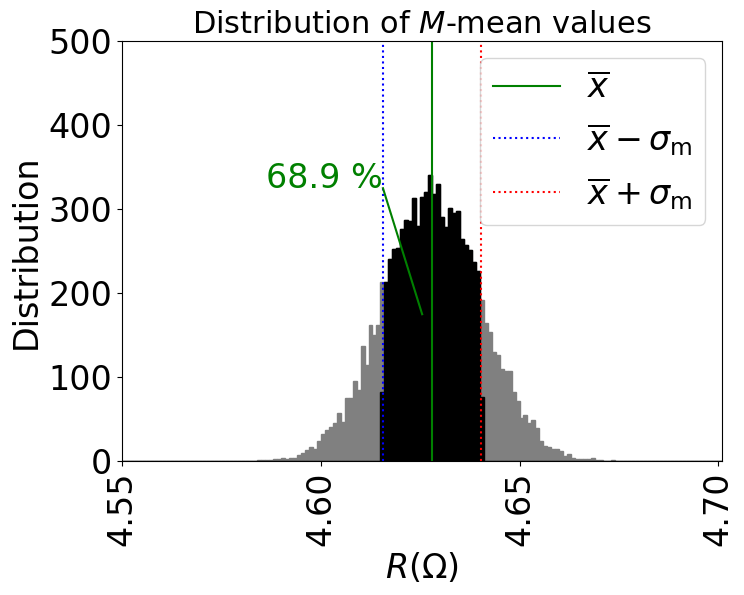

In [14]:
############################################
means_lower = np.mean( means ) - np.std( means )
means_upper = np.mean( means ) + np.std( means )
#
title = r'Distribution of $M$-mean values'
fig = GrfHistBound( np.array(means), means_lower, means_upper, '\sigma_{\\rm m}',
                    (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=500 )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-mean1sigma.pdf'
fig.savefig( pdf_path )

$M=4$の平均の分布の$1\epsilon$の範囲

<>:6: SyntaxWarning: invalid escape sequence '\e'
<>:6: SyntaxWarning: invalid escape sequence '\e'
C:\Users\iakai\AppData\Local\Temp\ipykernel_22716\588495688.py:6: SyntaxWarning: invalid escape sequence '\e'
  fig = GrfHistBound( np.array(means), means_lower, means_upper, '\epsilon_{\\rm m}',


ratio = 49.810 %


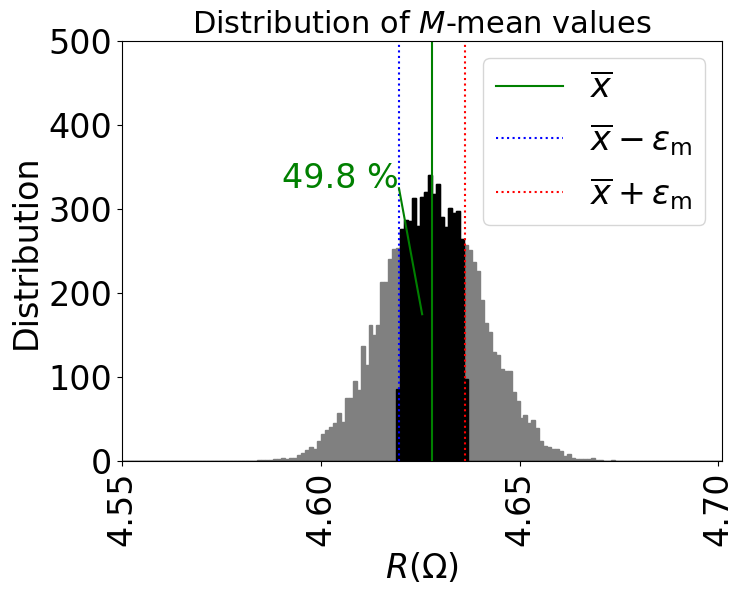

In [15]:
############################################
means_lower = np.mean( means ) - 0.6745 * np.std( means )
means_upper = np.mean( means ) + 0.6745 * np.std( means )
#
title = r'Distribution of $M$-mean values'
fig = GrfHistBound( np.array(means), means_lower, means_upper, '\epsilon_{\\rm m}',
                    (4.55, 0.001, 4.70), x_label=r'$R (\Omega$)', title=title, y_max=500 )
#
# 図をpdfに保存
pdf_path = FilePath + FileBaseName + '-mean1epsilon.pdf'
fig.savefig( pdf_path )